## Loading the dataset
After downloading the dataset from http://ufldl.stanford.edu/housenumbers/ in the second variant (32x32 images with a single number centered)

In [1]:
import matplotlib.pyplot as plt
import numpy as np, random, os
import tensorflow as tf
from tensorflow.keras import layers, models

#Read the datasets into memory
from scipy.io import loadmat

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
train_img, train_lbs = train['X'], train['y']
test_img, test_lbs = test['X'], test['y']

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((32, 32, 3, 73257), (73257, 1), (32, 32, 3, 26032), (26032, 1))

In [2]:
#reshape the arrays to have the sample number as the first index

train_img = np.transpose(train_img,[3,0,1,2])
test_img = np.transpose(test_img,[3,0,1,2])

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((73257, 32, 32, 3), (73257, 1), (26032, 32, 32, 3), (26032, 1))

In [3]:
#label for 0 is 10, change to 0 the label for 0

train_lbs = np.where(train_lbs!=10, train_lbs, 0)
test_lbs = np.where(test_lbs!= 10, test_lbs, 0)

In [4]:
def rgb_to_gray(rgb):
    r,g,b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989*r+0.5870*g+0.1140*b
    return gray.reshape(rgb.shape[0], rgb.shape[1], rgb.shape[2], 1)

In [5]:
train_img = rgb_to_gray(train_img)
test_img = rgb_to_gray(test_img)

## Extract a random validation set from the training set
In this case the size of the validation set is 10% of the training set.  
It is randomly extracted because the order of the images in the training set it's not random: consecutive images are part of the same original image with a complete house number.

In [6]:
#Divide training and validation
#validation set size is 10% of training set
validation_percentage = 0.1
validation_size = int(validation_percentage * train_img.shape[0])
#select the validation set as a random sample from the training set
random.seed(0) #chosen seed so the set is always the same
sample = random.sample(range(train_img.shape[0]), validation_size)
validation_img = train_img[sample,:,:,:]
train_img = np.delete(train_img, sample, 0)
validation_lbs = train_lbs[sample,:]
train_lbs = np.delete(train_lbs, sample, 0)

train_img.shape, validation_img.shape, train_lbs.shape, validation_lbs.shape

((65932, 32, 32, 1), (7325, 32, 32, 1), (65932, 1), (7325, 1))

## Visualize the images

In [7]:
#Function to visualize image with their respective labels
def plot_img_grayscale(images, labels, images_number=4):
    plt.figure(figsize=(8,8))
    for i in range(images_number**2):
        plt.subplot(images_number, images_number, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i,:,:,0], cmap='gray',vmin=0, vmax=255)
        # The labels happen to be arrays, 
        # which is why you need the extra index
        plt.xlabel(labels[i][0])
    plt.show()

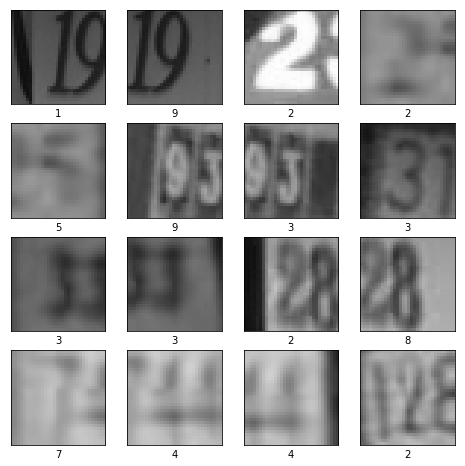

In [8]:
plot_img_grayscale(train_img, train_lbs)

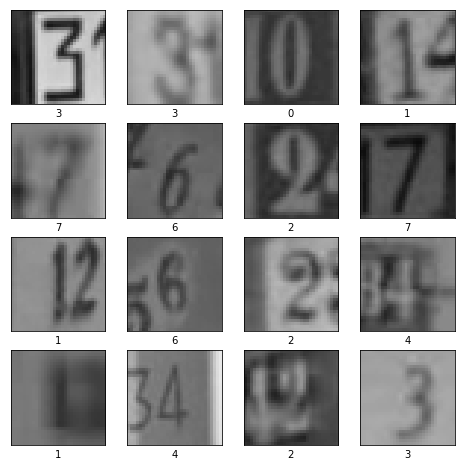

In [10]:
#Check if the validation set is divided correctely and print the data
plot_img_grayscale(validation_img, validation_lbs)

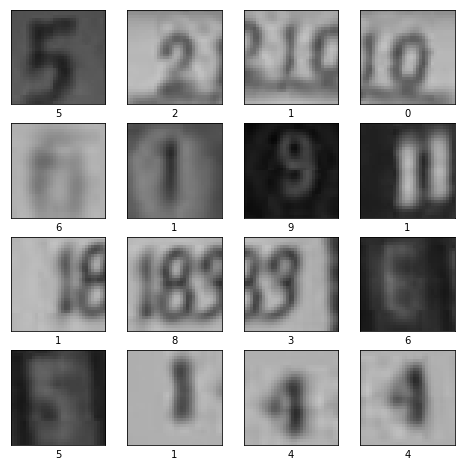

In [11]:
plot_img_grayscale(test_img, test_lbs)

## Data preprocessing

Two techniques are used in this order on the training set:

- **zero centering**: this is achieved by subctracting the mean of each colour channel across said colour channel.
- **normalization**: divide each colour channel by its standard deviation (calculated after zero centering).

The same techniques are applied also on the validation set and test set but using the same parameters (mean and standard deviation) obtained from the training set.

In [7]:
train_mean = np.mean(train_img)
train_img = train_img - train_mean
train_std = np.std(train_img)
train_img = train_img / train_std

#do the same for validation and test set
validation_img = validation_img - train_mean
validation_img = validation_img / train_std
test_img = test_img - train_mean
test_img = test_img / train_std

## Hyper-parameters Optimization

In [8]:
##hyper parameters network structure, batch size, learning rate, drop-out

#do the train
#see what hyperparameters do better on val set
#redo the trainign with the best parameters on val set + train set
#evaluate on training set

#adapt network architecture:
#try max pool instead of stride or vice versa
#try global avarage pooling vs fully connected

In [9]:
#train on 6 epochs
epoch_num = 6

#default batch size
batch = 64

#allows to save the weights for a model in a directory called dir_name
def checkpoint(dir_name):
    return tf.keras.callbacks.ModelCheckpoint(filepath=dir_name+'/cp-{epoch:02d}.hd5', verbose=0, period=3)

#learning rate decay call back    
learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [15]:
#define function to plot accuracy or loss
def plot_validation(number_of_models, history, loss=False):
    name, key, loc, f = 'Accuracy', 'acc', 'upper left', max
    if loss:
        name, key, loc, f = 'Loss', 'loss', 'lower left', min
    plt.figure(figsize=(8,3))
    for i in range(number_of_models):
        plt.plot(history[i].history['val_'+key], label='val_'+key+str(i))
        print("CNN {0}: Epochs={1:d}, Train {2}={3:.5f}, Validation {2}={4:.5f}".format(
            i,epoch_num,name,f(history[i].history[key]),f(history[i].history['val_'+key])))
    plt.title('Validation '+ name)
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.legend(loc='upper left')
    plt.show()

### Explain the basic structure on their hyper parameters
we are now going ot start hyperparameter evaluation

the basic network structure will be  
(conv2dLayer\* **N** (filterSize\* **L**) -> (maxPool or Stride))\***M** -> (FCnonlinear\***K** -> FCsoftmax) or (Global avarage pooling)

There are two typical architecture: conv layer followed by a max pooling or smaller conv layer followed by a conv layer with stride=2. Here the two are confronted giving each one roughly the same number of convolutional neurons.

In [11]:
val_models = []

models_number = 2
for i in range(models_number):
    model = models.Sequential()
    if i > 0:
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
        model.add(layers.Conv2D(16, (3,3), strides=2, activation='relu'))
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
        model.add(layers.Conv2D(32, (3,3), strides=2, activation='relu'))
    else:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/structure/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
21184/65932 [========>.....................] - ETA: 14s - loss: 1.1572 - acc: 0.6306

KeyboardInterrupt: 

CNN 0: Epochs=6, Train Accuracy=0.94646, Validation Accuracy=0.90239
CNN 1: Epochs=6, Train Accuracy=0.96099, Validation Accuracy=0.90922


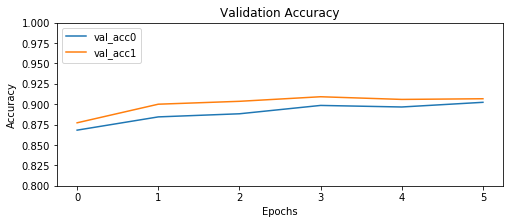

CNN 0: Epochs=6, Train Loss=0.18626, Validation Loss=0.36204
CNN 1: Epochs=6, Train Loss=0.13217, Validation Loss=0.31108


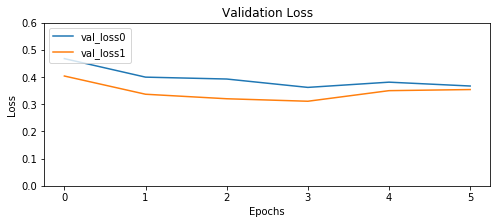

In [13]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

The second model (without max-pooling) performs better

### Validate the number of covolutional layers

In [14]:
val_models = []

models_number = 7
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    if i > 0:
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    if i > 3:
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i > 0:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i > 3:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3,3), strides=2, activation='relu'))
    
    if i == 2 or i == 5:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i == 3 or i == 6:
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [15]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/layers/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 14s 215us/sample - loss: 0.7579 - acc: 0.7606 - val_loss: 0.4876 - val_acc: 0.8504
Epoch 2/6
65932/65932 [==============================] - 14s 219us/sample - loss: 0.4002 - acc: 0.8817 - val_loss: 0.3797 - val_acc: 0.8874
Epoch 3/6
65932/65932 [==============================] - 14s 218us/sample - loss: 0.3092 - acc: 0.9082 - val_loss: 0.3654 - val_acc: 0.8889
Epoch 4/6
65932/65932 [==============================] - 14s 217us/sample - loss: 0.2526 - acc: 0.9242 - val_loss: 0.3611 - val_acc: 0.8954
Epoch 5/6
65932/65932 [==============================] - 14s 211us/sample - loss: 0.2055 - acc: 0.9396 - val_loss: 0.3562 - val_acc: 0.9001
Epoch 6/6
65932/65932 [==============================] - 14s 212us/sample - loss: 0.1655 - acc: 0.9505 - val_loss: 0.3927 - val_acc: 0.8960
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 34s 5

CNN 0: Epochs=6, Train Accuracy=0.95051, Validation Accuracy=0.90007
CNN 1: Epochs=6, Train Accuracy=0.95397, Validation Accuracy=0.91017
CNN 2: Epochs=6, Train Accuracy=0.95191, Validation Accuracy=0.91618
CNN 3: Epochs=6, Train Accuracy=0.96196, Validation Accuracy=0.91768
CNN 4: Epochs=6, Train Accuracy=0.94648, Validation Accuracy=0.91577
CNN 5: Epochs=6, Train Accuracy=0.94355, Validation Accuracy=0.91331
CNN 6: Epochs=6, Train Accuracy=0.95984, Validation Accuracy=0.91686


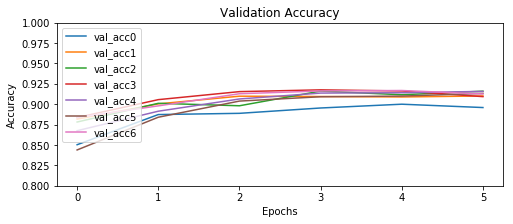

CNN 0: Epochs=6, Train Loss=0.16549, Validation Loss=0.35616
CNN 1: Epochs=6, Train Loss=0.15951, Validation Loss=0.30119
CNN 2: Epochs=6, Train Loss=0.16528, Validation Loss=0.28124
CNN 3: Epochs=6, Train Loss=0.13082, Validation Loss=0.28325
CNN 4: Epochs=6, Train Loss=0.18251, Validation Loss=0.29203
CNN 5: Epochs=6, Train Loss=0.19290, Validation Loss=0.29984
CNN 6: Epochs=6, Train Loss=0.13434, Validation Loss=0.28996


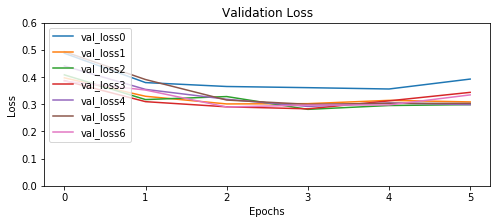

In [16]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

The third model performs better.

### Validate the number of filters per layer

In [20]:
val_models = []

models_number = 6
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(8+8*i, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(8+8*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(8+8*i, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(16+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16+16*i, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(16+16*i, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [21]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/filters/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 18s 279us/sample - loss: 0.8532 - acc: 0.7236 - val_loss: 0.4856 - val_acc: 0.8547
Epoch 2/6
65932/65932 [==============================] - 18s 270us/sample - loss: 0.4128 - acc: 0.8755 - val_loss: 0.3834 - val_acc: 0.8840
Epoch 3/6
65932/65932 [==============================] - 19s 288us/sample - loss: 0.3325 - acc: 0.9011 - val_loss: 0.3549 - val_acc: 0.8928
Epoch 4/6
65932/65932 [==============================] - 18s 272us/sample - loss: 0.2869 - acc: 0.9143 - val_loss: 0.3350 - val_acc: 0.9008
Epoch 5/6
65932/65932 [==============================] - 18s 267us/sample - loss: 0.2529 - acc: 0.9253 - val_loss: 0.3423 - val_acc: 0.9014
Epoch 6/6
65932/65932 [==============================] - 18s 269us/sample - loss: 0.2232 - acc: 0.9344 - val_loss: 0.3175 - val_acc: 0.9088
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 35s 5

CNN 0: Epochs=6, Train Accuracy=0.93439, Validation Accuracy=0.90881
CNN 1: Epochs=6, Train Accuracy=0.95626, Validation Accuracy=0.91495
CNN 2: Epochs=6, Train Accuracy=0.96516, Validation Accuracy=0.91782
CNN 3: Epochs=6, Train Accuracy=0.96475, Validation Accuracy=0.92369
CNN 4: Epochs=6, Train Accuracy=0.96578, Validation Accuracy=0.92055
CNN 5: Epochs=6, Train Accuracy=0.96589, Validation Accuracy=0.92587


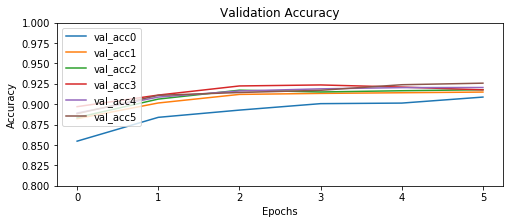

CNN 0: Epochs=6, Train Loss=0.22317, Validation Loss=0.31749
CNN 1: Epochs=6, Train Loss=0.14691, Validation Loss=0.28773
CNN 2: Epochs=6, Train Loss=0.11687, Validation Loss=0.28604
CNN 3: Epochs=6, Train Loss=0.12014, Validation Loss=0.27094
CNN 4: Epochs=6, Train Loss=0.11590, Validation Loss=0.27840
CNN 5: Epochs=6, Train Loss=0.11450, Validation Loss=0.26462


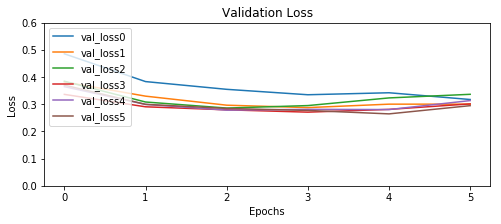

In [23]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

The sixth model is the better performing one.

In [ ]:
val_models[5].summary()

### Validate the number neurons in the fully connected layer

In [24]:
val_models = []

models_number = 5
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(48, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(48, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(48, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(96, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(64+64*i, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [25]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/FC/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 147s 2ms/sample - loss: 0.8053 - acc: 0.7367 - val_loss: 0.3549 - val_acc: 0.8916
Epoch 2/6
65932/65932 [==============================] - 147s 2ms/sample - loss: 0.3031 - acc: 0.9114 - val_loss: 0.3089 - val_acc: 0.9069
Epoch 3/6
65932/65932 [==============================] - 152s 2ms/sample - loss: 0.2354 - acc: 0.9324 - val_loss: 0.2653 - val_acc: 0.9203
Epoch 4/6
65932/65932 [==============================] - 163s 2ms/sample - loss: 0.1907 - acc: 0.9444 - val_loss: 0.2662 - val_acc: 0.9234
Epoch 5/6
65932/65932 [==============================] - 153s 2ms/sample - loss: 0.1522 - acc: 0.9556 - val_loss: 0.2742 - val_acc: 0.9207
Epoch 6/6
65932/65932 [==============================] - 163s 2ms/sample - loss: 0.1220 - acc: 0.9642 - val_loss: 0.2986 - val_acc: 0.9244
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 159s 2ms/sa

CNN 0: Epochs=6, Train Accuracy=0.96422, Validation Accuracy=0.92437
CNN 1: Epochs=6, Train Accuracy=0.96780, Validation Accuracy=0.92669
CNN 2: Epochs=6, Train Accuracy=0.97153, Validation Accuracy=0.91891
CNN 3: Epochs=6, Train Accuracy=0.97531, Validation Accuracy=0.92532
CNN 4: Epochs=6, Train Accuracy=0.96839, Validation Accuracy=0.91891


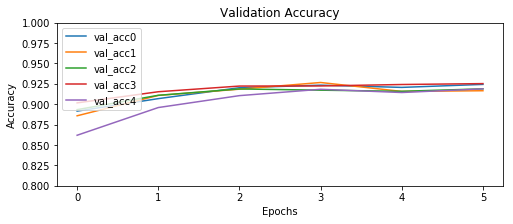

CNN 0: Epochs=6, Train Loss=0.12205, Validation Loss=0.26532
CNN 1: Epochs=6, Train Loss=0.10826, Validation Loss=0.25757
CNN 2: Epochs=6, Train Loss=0.09482, Validation Loss=0.28149
CNN 3: Epochs=6, Train Loss=0.08204, Validation Loss=0.27005
CNN 4: Epochs=6, Train Loss=0.10554, Validation Loss=0.27358


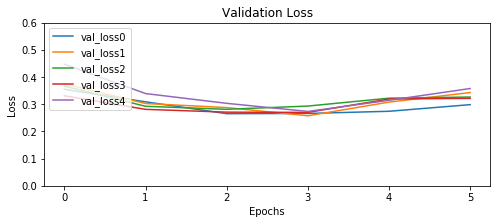

In [26]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

The best performing model is the second, with 128 neurons.

### Validate droput

In [11]:
val_models = []

droput = [0.1,0.2,0.3,0.4,0.5,0.6]

models_number = 6
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(48, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(48, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(48, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(96, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(droput[i]))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/dropout/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 142s 2ms/sample - loss: 0.7937 - acc: 0.7422 - val_loss: 0.3757 - val_acc: 0.8898
Epoch 2/6
65932/65932 [==============================] - 140s 2ms/sample - loss: 0.3169 - acc: 0.9075 - val_loss: 0.2950 - val_acc: 0.9140
Epoch 3/6
65932/65932 [==============================] - 141s 2ms/sample - loss: 0.2474 - acc: 0.9270 - val_loss: 0.2923 - val_acc: 0.9152
Epoch 4/6
65932/65932 [==============================] - 141s 2ms/sample - loss: 0.2024 - acc: 0.9410 - val_loss: 0.2705 - val_acc: 0.9216
Epoch 5/6
65932/65932 [==============================] - 141s 2ms/sample - loss: 0.1615 - acc: 0.9517 - val_loss: 0.2966 - val_acc: 0.9203
Epoch 6/6
65932/65932 [==============================] - 142s 2ms/sample - loss: 0.1311 - acc: 0.9609 - val_loss: 0.3079 - val_acc: 0.9225
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 153s 2ms/sa

CNN 0: Epochs=6, Train Accuracy=0.96094, Validation Accuracy=0.92246
CNN 1: Epochs=6, Train Accuracy=0.95897, Validation Accuracy=0.92860
CNN 2: Epochs=6, Train Accuracy=0.95207, Validation Accuracy=0.92451
CNN 3: Epochs=6, Train Accuracy=0.94819, Validation Accuracy=0.92737
CNN 4: Epochs=6, Train Accuracy=0.94415, Validation Accuracy=0.93160
CNN 5: Epochs=6, Train Accuracy=0.94015, Validation Accuracy=0.92573


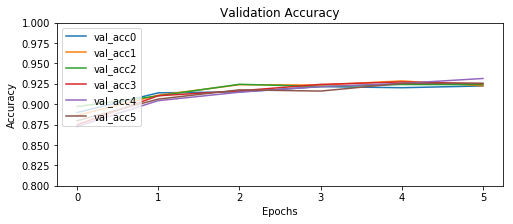

CNN 0: Epochs=6, Train Loss=0.13114, Validation Loss=0.27049
CNN 1: Epochs=6, Train Loss=0.14017, Validation Loss=0.26602
CNN 2: Epochs=6, Train Loss=0.16536, Validation Loss=0.27570
CNN 3: Epochs=6, Train Loss=0.18481, Validation Loss=0.26348
CNN 4: Epochs=6, Train Loss=0.20039, Validation Loss=0.26021
CNN 5: Epochs=6, Train Loss=0.21477, Validation Loss=0.26585


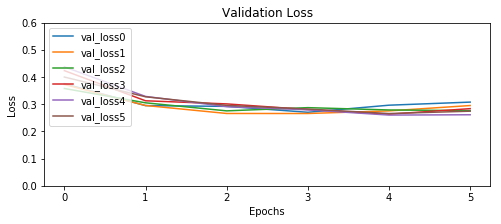

In [13]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

The fifth model exhibits the best performances

### Validate the batch size

In [15]:
val_models = []

models_number = 6
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(48, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(48, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(48, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(96, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [16]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/batch/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=24+i*24, epochs=epoch_num+3,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/9
65932/65932 [==============================] - 292s 4ms/sample - loss: 0.9152 - acc: 0.7083 - val_loss: 0.3873 - val_acc: 0.8834
Epoch 2/9
65932/65932 [==============================] - 290s 4ms/sample - loss: 0.4070 - acc: 0.8842 - val_loss: 0.3362 - val_acc: 0.8986
Epoch 3/9
65932/65932 [==============================] - 294s 4ms/sample - loss: 0.3319 - acc: 0.9060 - val_loss: 0.3027 - val_acc: 0.9137
Epoch 4/9
65932/65932 [==============================] - 291s 4ms/sample - loss: 0.2901 - acc: 0.9196 - val_loss: 0.2997 - val_acc: 0.9170
Epoch 5/9
65932/65932 [==============================] - 289s 4ms/sample - loss: 0.2540 - acc: 0.9285 - val_loss: 0.3178 - val_acc: 0.9095
Epoch 6/9
65932/65932 [==============================] - 291s 4ms/sample - loss: 0.2229 - acc: 0.9360 - val_loss: 0.2972 - val_acc: 0.9188
Epoch 7/9
65932/65932 [==============================] - 291s 4ms/sample - loss: 0.1985 - acc: 0.9440 - val_loss: 0.2

CNN 0: Epochs=6, Train Accuracy=0.95500, Validation Accuracy=0.92491
CNN 1: Epochs=6, Train Accuracy=0.96346, Validation Accuracy=0.92942
CNN 2: Epochs=6, Train Accuracy=0.96434, Validation Accuracy=0.93119
CNN 3: Epochs=6, Train Accuracy=0.96615, Validation Accuracy=0.93311
CNN 4: Epochs=6, Train Accuracy=0.96307, Validation Accuracy=0.92792
CNN 5: Epochs=6, Train Accuracy=0.96399, Validation Accuracy=0.93010


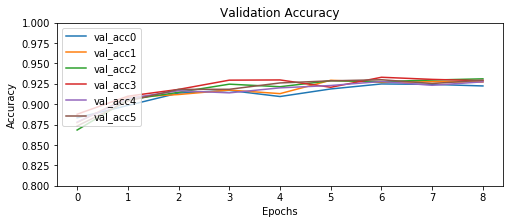

CNN 0: Epochs=6, Train Loss=0.15694, Validation Loss=0.27785
CNN 1: Epochs=6, Train Loss=0.12715, Validation Loss=0.28079
CNN 2: Epochs=6, Train Loss=0.12525, Validation Loss=0.26528
CNN 3: Epochs=6, Train Loss=0.11612, Validation Loss=0.25996
CNN 4: Epochs=6, Train Loss=0.13000, Validation Loss=0.27302
CNN 5: Epochs=6, Train Loss=0.12691, Validation Loss=0.25573


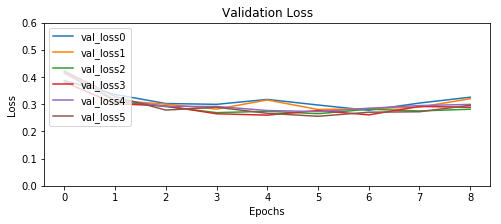

In [18]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

In [11]:
best_batch_size = 144

### Validate Learning rate

In [12]:
val_models = []

models_number = 5
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(48, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(48, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(48, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(96, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
#create multiple learning rates
def lrd(i):
    return tf.keras.callbacks.LearningRateScheduler(lambda x: 10**-3 * (0.65 - (0.025*i )) ** x, verbose=0)

In [14]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/learning_rate/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=best_batch_size, epochs=epoch_num+2+i,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  lrd(i)]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/8
65932/65932 [==============================] - 150s 2ms/sample - loss: 1.0519 - acc: 0.6512 - val_loss: 0.4166 - val_acc: 0.8745
Epoch 2/8
65932/65932 [==============================] - 148s 2ms/sample - loss: 0.4169 - acc: 0.8784 - val_loss: 0.3208 - val_acc: 0.9070
Epoch 3/8
65932/65932 [==============================] - 149s 2ms/sample - loss: 0.3201 - acc: 0.9076 - val_loss: 0.2861 - val_acc: 0.9185
Epoch 4/8
65932/65932 [==============================] - 149s 2ms/sample - loss: 0.2668 - acc: 0.9239 - val_loss: 0.2747 - val_acc: 0.9225
Epoch 5/8
65932/65932 [==============================] - 149s 2ms/sample - loss: 0.2303 - acc: 0.9342 - val_loss: 0.2837 - val_acc: 0.9245
Epoch 6/8
65932/65932 [==============================] - 150s 2ms/sample - loss: 0.2052 - acc: 0.9426 - val_loss: 0.2554 - val_acc: 0.9308
Epoch 7/8
65932/65932 [==============================] - 150s 2ms/sample - loss: 0.1883 - acc: 0.9478 - val_loss: 0.2

CNN 0: Epochs=6, Train Accuracy=0.95069, Validation Accuracy=0.93311
CNN 1: Epochs=6, Train Accuracy=0.95391, Validation Accuracy=0.93038
CNN 2: Epochs=6, Train Accuracy=0.95383, Validation Accuracy=0.93038
CNN 3: Epochs=6, Train Accuracy=0.94801, Validation Accuracy=0.93147
CNN 4: Epochs=6, Train Accuracy=0.95169, Validation Accuracy=0.93038


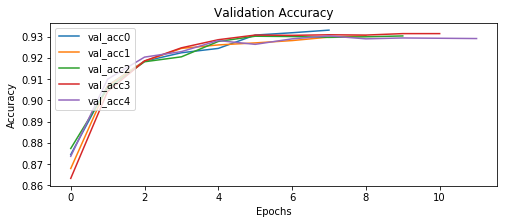

CNN 0: Epochs=6, Train Loss=0.17730, Validation Loss=0.25537
CNN 1: Epochs=6, Train Loss=0.17086, Validation Loss=0.25551
CNN 2: Epochs=6, Train Loss=0.16732, Validation Loss=0.25480
CNN 3: Epochs=6, Train Loss=0.18811, Validation Loss=0.26131
CNN 4: Epochs=6, Train Loss=0.17772, Validation Loss=0.25749


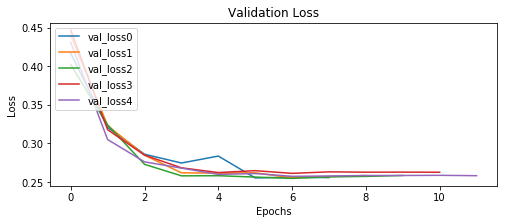

In [16]:
plot_validation(models_number, val_errors)

plot_validation(models_number, val_errors, loss=True)

The thrid model performs better.

### Train the model on the whole training set (train + validation renormalized)

In [17]:
#create multiple learning rates
def lrd(i):
    return tf.keras.callbacks.LearningRateScheduler(lambda x: 10**-3 * (0.65 - (0.025*i )) ** x, verbose=0)

best_lr = lrd(2)
best_batch_size = 144

In [18]:
#reload the datasets and renormalize them, without splitting the validation set.
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
train_img, train_lbs = train['X'], train['y']
test_img, test_lbs = test['X'], test['y']

train_img = np.transpose(train_img,[3,0,1,2])
test_img = np.transpose(test_img,[3,0,1,2])

train_lbs = np.where(train_lbs!=10, train_lbs, 0)
test_lbs = np.where(test_lbs!= 10, test_lbs, 0)

In [19]:
def rgb_to_gray(rgb):
    r,g,b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989*r+0.5870*g+0.1140*b
    return gray.reshape(rgb.shape[0], rgb.shape[1], rgb.shape[2], 1)

train_img = rgb_to_gray(train_img)
test_img = rgb_to_gray(test_img)

In [20]:
train_mean = np.mean(train_img)
train_img = train_img - train_mean
train_std = np.std(train_img)
train_img = train_img / train_std

#do the same for the test set
test_img = test_img - train_mean
test_img = test_img / train_std

In [21]:
#create the final model
model = models.Sequential()
    
model.add(layers.Conv2D(48, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
model.add(layers.Conv2D(48, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(48, (3,3), strides=2, activation='relu'))

model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(96, (3,3), strides=2, activation='relu'))
    
model.add(layers.Conv2D(96, (3,3), padding='same', activation='relu'))
        
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/training/model'
os.makedirs(base_name, exist_ok=True)

#train it
history = model.fit(train_img, train_lbs, batch_size=best_batch_size, epochs=10, validation_data=(test_img, test_lbs),
                    verbose = 1, callbacks=[checkpoint(base_name), best_lr])

Train on 73257 samples, validate on 26032 samples
Epoch 1/10
73257/73257 [==============================] - 175s 2ms/sample - loss: 1.0779 - acc: 0.6404 - val_loss: 0.3923 - val_acc: 0.8838
Epoch 2/10
73257/73257 [==============================] - 171s 2ms/sample - loss: 0.3843 - acc: 0.8894 - val_loss: 0.3161 - val_acc: 0.9108
Epoch 3/10
73257/73257 [==============================] - 180s 2ms/sample - loss: 0.2965 - acc: 0.9161 - val_loss: 0.2833 - val_acc: 0.9207
Epoch 4/10
73257/73257 [==============================] - 181s 2ms/sample - loss: 0.2454 - acc: 0.9310 - val_loss: 0.2572 - val_acc: 0.9284
Epoch 5/10
73257/73257 [==============================] - 178s 2ms/sample - loss: 0.2163 - acc: 0.9403 - val_loss: 0.2553 - val_acc: 0.9313
Epoch 6/10
73257/73257 [==============================] - 192s 3ms/sample - loss: 0.1956 - acc: 0.9461 - val_loss: 0.2493 - val_acc: 0.9333
Epoch 7/10
73257/73257 [==============================] - 192s 3ms/sample - loss: 0.1826 - acc: 0.9498 - val_l

CNN 0: Epochs=6, Train Accuracy=0.95404, Validation Accuracy=0.93404


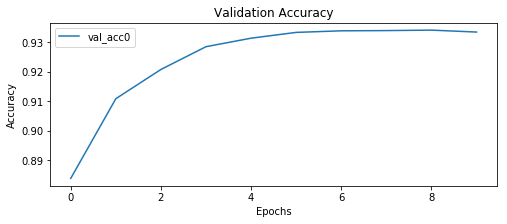

CNN 0: Epochs=6, Train Loss=0.16713, Validation Loss=0.24931


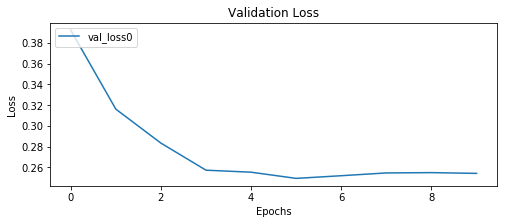

In [23]:
plot_validation(1, [history])

plot_validation(1, [history], loss=True)

In [ ]:
model.evaluate(test_img, test_lbs)